In [1]:
!pip install -q -U einops datasets matplotlib tqdm

References
==========

https://huggingface.co/blog/annotated-diffusion
https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

In [1]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

/home/mtman/miniconda3/envs/ddpm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Network Helpers
def exists(x):
    return x is not None

def default(val,d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def num_to_groups(num, divisor):
    ## Calcs for group normalization
    groups = num // divisor
    remainder = num % divisor
    arr=[divisor]*groups
    if remainder>0:
        arr.append(remainder)
    return arr

class Residual(nn.Module):
    def __init__(self,fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x,*args,**kwargs) + x
    
def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),nn.Conv2d(dim, default(dim_out,dim),3,padding=1)        
    )

def Downsample(dim, dim_out=None):
    # Assumes image was scaled up with Upsample. Rearrange by splitting out original images and organizing along channel dimension. Then apply 1d convolution. 
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )  
    



In [22]:
# Positional embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    # https://arxiv.org/pdf/1706.03762.pdf Numerically stable way to calcuate the sinusoidal position embedding. The motivation for this choice appears to be thinking of the position as projecting the 1-D position value 
    # into the same dimension space as the model where dimension i corresponds to a frequency component wiht angular frequency of 2*pi*(10000)^(i/(dim/2)) which ranges from 2*pi to 10000*2pi whcih can be thought of as fourier components.
    # The authors acknowlege this is arbitrary but argue for it on the basis of this projected co-ordinate system would allow relative positions PE_{pos+k} to be calculated as a linear function of the encoding of PE_{pos+k}


    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) #  exp{log (10^-5)^(i/(dim/2))}
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)  #will be of length dim
        return embeddings

In [23]:
# Resnet block: The original paper uses wide resnet blocks but another experimenter replaced the convolution layer with a weighted standardized version which apparently works better with 
# group normalization https://arxiv.org/abs/1912.11370. Perhaps this is because in group norm we take subsets of channels and perform the operations in parallel. If the states of the groups of channels of G,H,W are different then it 
# 

class WeightedStandardizedConv2d(nn.Conv2d):

    def forward(self,x):
        eps = 1e-5 if x.dtype==torch.float32 else 1e-3
        
        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean") # mean over each of the RGB channels. Keep dims
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False)) # var over each of the RGB chanells. Keep dims
        normalized_weight = (weight - mean) * (var + eps).rsqrt() # rsqrt (reciprocal sqrt ... really :) ) 

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

In [24]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightedStandardizedConv2d(dim,dim_out,3, padding=1)  #
        self.norm=nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()
    
    def forward(self, x, scale_shift=None):
        x=self.proj(x)
        x=self.norm(x)
        if exists(scale_shift):
            #scale and shift terms come from the fourier transform interpretation of the sinusoidal position embedding. F(w) = \int_-inf^inf f(t).exp(-iwt)dt. let f(t)->f(t-\del t) => exp(-iw\del t)F(W) phase shift.
            scale, shift = scale_shift
            x=x*(scale+1)+shift
        x=self.act(x)
        return x


In [25]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp=nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out*2)) if exists(time_emb_dim) else None

        self.block1=Block(dim, dim_out, groups=groups)
        self.block2=Block(dim_out,dim_out,groups=groups)
        self.res_conv=nn.Conv2d(dim, dim_out,1) if dim!=dim_out else nn.Identity() # Either skip connection if input and output dimensions are the same otherwise a 1x1 convolution

    def forward(self,x, time_emb=None):
        scale_shift= None
        if exists(self.mlp) and exists(time_emb):
            time_emb=self.mlp(time_emb)
            time_emb=rearrange(time_emb, "b c -> b c 1 1")
            scale_shift=time_emb.chunk(2,dim=1)   # (sin , cos) of time encoding
        h=self.block1(x,scale_shift=scale_shift)
        h=self.block2(h)
        return h+self.res_conv(x)

In [41]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False) # 1x1 convolution used to create random projections for Q K and V from the input image.
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self,x):
        # Attention is applied between convolution layers in the Unet arch. Each channel is the results of different convolution filters so can be thought of different embeddings of the visual tokens. 
        # In Multihead attention each head represents a different 'reference plane' whcih in the NLP context represent different embedding subspaces and it is hoped that each captures different aspects of the semantics. 
        # By analoge, multihead attention in image context, each channel the projection of the image onto a different subspace (via convolution filters) with the hope that each captures different semantics. The variation is that
        # in NLP each head deals with a sequence of token embeddings, in the current paradigm for handling images each channel corresponds to one token and output convolution is the embedding of that token. 
        # 
        b, c, h, w = x.shape
        qkv=self.to_qkv(x).chunk(3,dim=1)   # split the composite qkv created from the random projections ( 1x1 convolutions) . Returns list of 3 tensors.
        q,k,v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)',h=self.heads),qkv) #split out q k v for each head h, and unroll the 2d projections of the image 

        q=q*self.scale
        # sim = einsum('b h d i, b h d j -> b h i j', q, k) # inner product along the channel dimension gives the i,j-th 'pixel' similarity across 
        sim = einsum('b h i e, b h j e -> b h i j', q, k) # inner product along the channel dimension gives the i,j-th 'pixel' similarity across 
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn=sim.softmax(dim=-1)

        out = einsum("b h i j, b h j d -> b h i d", attn, v) # this was wrong in the blog. 
        out = rearrange(out, "b h d (x y) -> b (h d) x y", x=h, y=w)
        return self.to_out(out)
    
class LinearAttention(nn.Module):
    '''https://arxiv.org/ftp/arxiv/papers/2007/2007.14902.pdf
        Linear attention idea development starts with characterising the softmax matmult of QK with V as a specific instance of kernel operation. The choose first order taylor series approximatino to the softmax to get a linear attention mechanism
        that is computationally more efficient.

    '''
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [42]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        # Groupnorm with 1 group is layer norm
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [43]:
'''
    Conditional Unet.
'''
class Unet(nn.Module):
    def __init__(
            self,
            dim,
            init_dim=None,
            out_dim=None,
            dim_mults=(1,2,4,8),
            channels=3,
            self_condition=False,
            resnet_block_groups=4
    ):
        super().__init__()

        self.channels = channels # starts at RGB
        self.self_condition = self_condition
        input_channels = channels* (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1 , padding =0) 
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # init_dim defaults to dim if no value passed in. 
        in_out = list(zip(dims[:-1], dims[1:])) # the input to output dimension changes for downsample, upsample

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)  # resnet_block_groups is for group norm in resnetblock. Values used are 4 and 8. Note this works in conjunction with normalised weight conv2d

        # The FCN in transformer block do a 4 x dim expansion and then a projection. This is applying the same operation to time embedding. 
        time_dim = dim*4 
        self.time_mlp = nn.Sequential(SinusoidalPositionEmbeddings(dim),
                                      nn.Linear(dim, time_dim),
                                      nn.GELU(),
                                      nn.Linear(time_dim, time_dim),)
        
        self.downs=nn.ModuleList([]) # registers all modules in list for __all__
        self.ups=nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind>=(num_resolutions-1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out)
                if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding =1),
            ]))
        
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone() 

        t = self.time_mlp(time)  # time is passed through 2 MLP's and not sure why? 

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


In [44]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'

image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC


In [45]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1), # shift to [-1,1] to make the values centered around zero to align with the initial noise sample for the reverse process which is drawn from a std normal
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

In [46]:
unet = Unet(dim=image_size,channels =3, dim_mults=(1,2,4,))
unet

Unet(
  (init_conv): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (block1): Block(
          (proj): WeightedStandardizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 128, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightedStandardizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 128, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): 

In [53]:
x_start.shape
time=torch.tensor([40])
a=unet(x_start, time)
a.shape

torch.Size([1, 3, 128, 128])

In [58]:
import numpy as np
reverse_transform = Compose([
    Lambda(lambda t: (t+1)/2),
    Lambda(lambda t: t.permute(1,2,0)), #CHW to HWC
    Lambda(lambda t: t*255.),
    Lambda(lambda t:t.numpy().astype(np.uint8)),
    ToPILImage(),
])

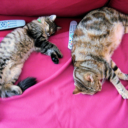

In [60]:
reverse_transform(x_start.squeeze().detach())

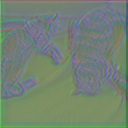

In [59]:
a=a.squeeze(0).detach()
reverse_transform(a)

In [12]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start